In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px

import os
import warnings

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering 

from sklearn.preprocessing import LabelEncoder

from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

from scipy.spatial.distance import pdist, squareform

from statsmodels.tsa.seasonal import seasonal_decompose, STL


Данные для 81 региона с 2005 по 2023 помесячно


In [2]:
df = pd.read_csv('./russia_alcohol_monthly.csv')
df.head()


,dt,region,wine,beer,vodka,champagne,brandy
0,2005-01-01,Republic of Adygea,0.1810,0.7384,0.4442,0.0268,0.0144
1,2005-02-01,Republic of Adygea,0.1028,1.0459,0.3165,0.0251,0.0077
2,2005-03-01,Republic of Adygea,0.1911,1.0155,0.1589,0.0117,0.0076
3,2005-04-01,Republic of Adygea,0.1340,0.5658,0.2294,0.0322,0.0039
4,2005-05-01,Republic of Adygea,0.1646,0.7004,0.3395,0.0346,0.0124


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18468 entries, 0 to 18467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dt         18468 non-null  object 
 1   region     18468 non-null  object 
 2   wine       18468 non-null  float64
 3   beer       18468 non-null  float64
 4   vodka      18468 non-null  float64
 5   champagne  18468 non-null  float64
 6   brandy     18468 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1010.1+ KB


In [4]:
df.describe()

,wine,beer,vodka,champagne,brandy
count,18468.000000,18468.000000,18468.000000,18468.000000,18468.000000
mean,0.469795,4.310183,0.991867,0.109597,0.043682
std,0.296131,2.657150,0.563601,0.080427,0.038216
min,0.003400,0.017600,0.009600,0.001700,0.000000
25%,0.243900,2.311575,0.573650,0.053100,0.016600
50%,0.415800,3.847350,0.906700,0.092000,0.032900
75%,0.634025,5.856025,1.317175,0.143300,0.058000
max,2.363100,22.126300,5.565200,0.749700,0.277400


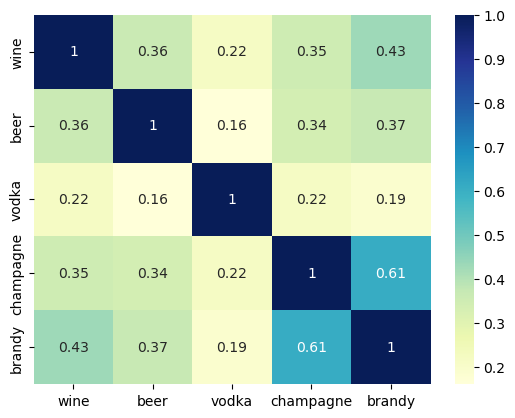

In [5]:
d_df = df[['wine','beer','vodka', 'champagne', 'brandy']]
dataplot = sns.heatmap(d_df.corr(numeric_only=True), cmap="YlGnBu", annot=True)
plt.show()


In [6]:
df.isna().sum()

dt           0
region       0
wine         0
beer         0
vodka        0
champagne    0
brandy       0
dtype: int64

In [7]:
#data_pivot = df.pivot(index='region', columns='date', values='wine')
#data_pivot
df['dt'] = pd.to_datetime(df['dt'])
#df[(df['dt'].dt.year == 2005) & (df['region'] == 'Moscow')]['wine'].sum()

In [8]:
df_Moscow = df[df['region'] == 'Moscow']  # создам срез для Москвы
 
df_Moscow.index

Index([8436, 8437, 8438, 8439, 8440, 8441, 8442, 8443, 8444, 8445,
       ...
       8654, 8655, 8656, 8657, 8658, 8659, 8660, 8661, 8662, 8663],
      dtype='int64', length=228)

In [9]:
df_Moscow["total_alcohol"] = (
      df_Moscow["wine"]
    + df_Moscow["brandy"]
    + df_Moscow["vodka"]
    + df_Moscow["beer"]
    + df_Moscow["champagne"]
)

/var/folders/y5/24l_kybn3bdgl94q31jdb_1h0000gp/T/ipykernel_11039/1015052858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Moscow["total_alcohol"] = (


In [10]:
# проверить, что dt  в индексе
#df_Moscow = df_Moscow.reset_index() 
df_Moscow['day'] = df_Moscow.dt.dt.day
df_Moscow['month'] = df_Moscow.dt.dt.month
df_Moscow['year'] = df_Moscow.dt.dt.year
##df_Moscow = df.set_index('dt')
#df["month"] = df.Date.dt.month
#df["week"] = df.Date.dt.week
#df["day"] = df.Date.dt.day
df_Moscow.dt.dt

/var/folders/y5/24l_kybn3bdgl94q31jdb_1h0000gp/T/ipykernel_11039/208786101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Moscow['day'] = df_Moscow.dt.dt.day
/var/folders/y5/24l_kybn3bdgl94q31jdb_1h0000gp/T/ipykernel_11039/208786101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Moscow['month'] = df_Moscow.dt.dt.month
/var/folders/y5/24l_kybn3bdgl94q31jdb_1h0000gp/T/ipykernel_11039/208786101.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [11]:

df_Moscow


,dt,region,wine,beer,vodka,champagne,brandy,total_alcohol,day,month,year
8436,2005-01-01,Moscow,0.8230,3.1166,1.6852,0.4612,0.0824,6.1684,1,1,2005
8437,2005-02-01,Moscow,0.2910,2.7856,1.8722,0.1713,0.0291,5.1492,1,2,2005
8438,2005-03-01,Moscow,0.4332,2.1426,1.8865,0.4880,0.0847,5.0350,1,3,2005
8439,2005-04-01,Moscow,0.7274,1.6078,1.0326,0.0844,0.0803,3.5325,1,4,2005
8440,2005-05-01,Moscow,0.5896,3.4449,2.3502,0.3320,0.0811,6.7978,1,5,2005
...,...,...,...,...,...,...,...,...,...,...,...
8659,2023-08-01,Moscow,0.4031,4.2487,0.5960,0.2555,0.1224,5.6257,1,8,2023
8660,2023-09-01,Moscow,0.1505,5.6994,1.4949,0.3118,0.0670,7.7236,1,9,2023
8661,2023-10-01,Moscow,0.8359,3.9064,0.3863,0.2941,0.0996,5.5223,1,10,2023
8662,2023-11-01,Moscow,0.3343,8.5722,0.5693,0.1078,0.1204,9.7040,1,11,2023


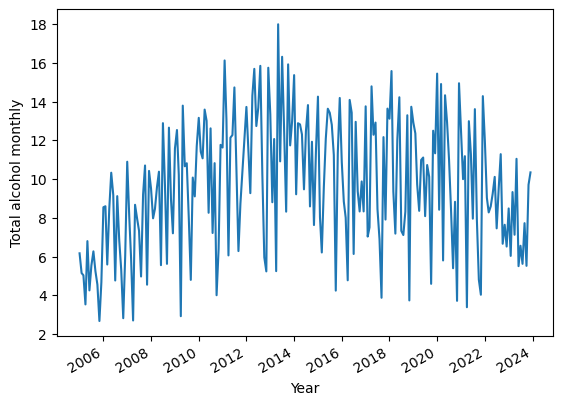

<Figure size 1500x700 with 0 Axes>

In [14]:
fig, ax = plt.subplots()
plt.figure(figsize=(15,7))
ax.plot(df_Moscow.total_alcohol)
ax.set_xlabel('Year')
ax.set_ylabel('Total alcohol monthly')

fig.autofmt_xdate()
plt.tight_layout()


In [13]:
df_Moscow = df_Moscow.set_index('dt')
#df_Moscow = df_Moscow.reset_index()

In [15]:
advanced_decomposition = STL(df_Moscow.total_alcohol, period=2).fit()


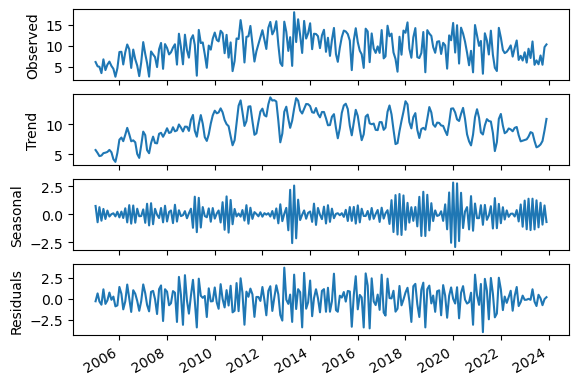

<Figure size 1500x800 with 0 Axes>

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)
plt.figure(figsize=(15,8))
ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


#plt.xticks(np.arange(0, 19, 1), [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,2016])

fig.autofmt_xdate()
plt.tight_layout()


In [17]:

from sklearn.metrics import mean_squared_error
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# close warnings
warnings.filterwarnings('ignore')

In [18]:
adf_test = adfuller(df_Moscow["total_alcohol"])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.415379
p-value: 0.137443


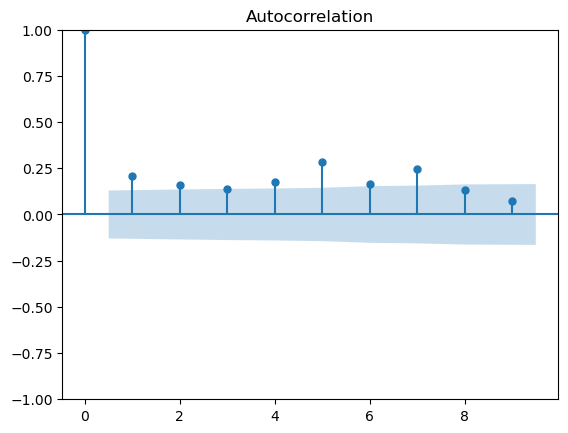

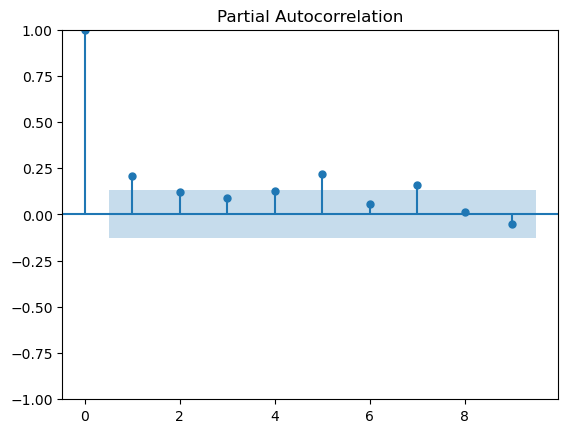

In [19]:
plot_acf(df_Moscow['total_alcohol'], lags=9)
plot_pacf(df_Moscow['total_alcohol'], lags=9)
plt.show()

Автокорреляция (ACF) и частичная автокорреляция (PACF) — это важные инструменты для анализа временных рядов и определения их стационарности.

▎График ACF (Autocorrelation Function)

1. Определение: ACF показывает, насколько текущие значения временного ряда коррелируют с его прошлыми значениями на различных лагах.
2. Интерпретация:
   - Если ACF убывает медленно и остается значимой на больших лагах, это может указывать на нестационарность, например, на наличие тренда.
   - Если ACF быстро убывает, это может свидетельствовать о стационарности.

▎График PACF (Partial Autocorrelation Function)

1. Определение: PACF показывает, как текущие значения временного ряда коррелируют с его прошлыми значениями, исключая влияние промежуточных значений.
2. Интерпретация:
   - Если PACF обрывается после определенного лага (например, на первом или втором), это может указывать на наличие авторегрессионной структуры (AR).
   - Если PACF убывает медленно, это может свидетельствовать о нестационарности.

▎Выводы о стационарности

- Значащая автокорреляция: Если вы наблюдаете значащую автокорреляцию на ACF и/или PACF, это может указывать на то, что временной ряд не является стационарным. Например, если ACF показывает длительную автокорреляцию, это может свидетельствовать о наличии тренда или сезонности.
  
- Тесты на стационарность: Для окончательной проверки стационарности можно использовать тесты, такие как тест Дики-Фуллера или KPSS-тест.

▎Резюме

- Стационарные ряды: ACF быстро убывает, PACF обрывается.
- Нестационарные ряды: ACF медленно убывает, PACF может показывать значимые значения на многих лагах.

Таким образом, анализируя графики ACF и PACF, вы можете сделать выводы о структуре временного ряда и его стационарности.

In [20]:
model = ARIMA(df_Moscow['total_alcohol'], order=(1, 1, 1))
model_fit = model.fit()
model_fit

In [25]:
df_Moscow.isna().sum()

dt               0
region           0
wine             0
beer             0
vodka            0
champagne        0
brandy           0
total_alcohol    0
day              0
month            0
year             0
dtype: int64

In [21]:
forecast = model_fit.get_forecast(steps=30)

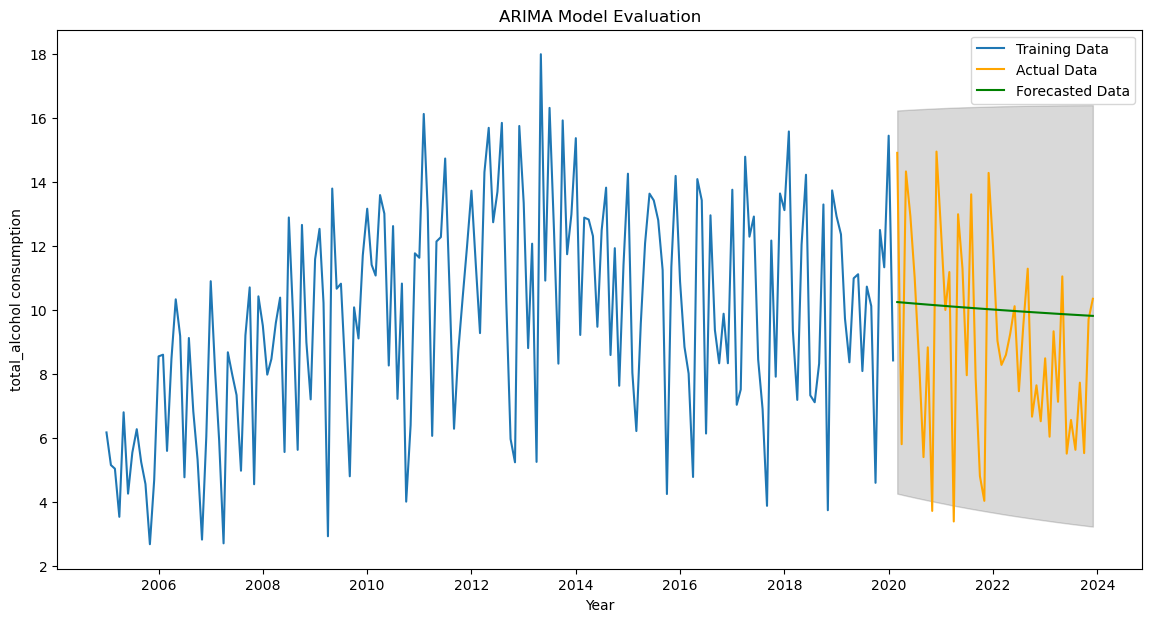

RMSE: 3.183832913257126


In [22]:
# Split the data into train and test
train_size = int(len(df_Moscow) * 0.8)
train, test = df_Moscow[0:train_size], df_Moscow[train_size:len(df_Moscow)+1]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['total_alcohol'], order=(1, 0, 1))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['total_alcohol'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['total_alcohol'], label='Training Data')
plt.plot(test['total_alcohol'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Year')
plt.ylabel('total_alcohol consumption')
plt.legend()
plt.show()

print('RMSE:', rmse)

RangeIndex(start=0, stop=228, step=1)

In [23]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

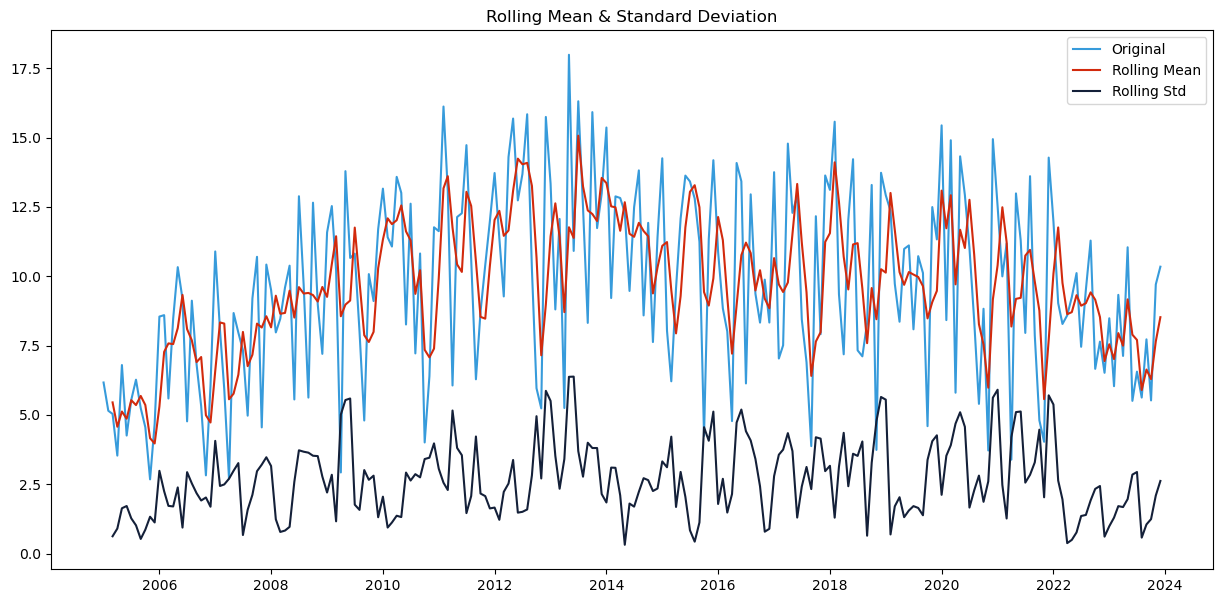

In [24]:
#Determine rolling statistics
df_Moscow["rolling_avg"] = df_Moscow["total_alcohol"].rolling(window=3).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df_Moscow["rolling_std"] = df_Moscow["total_alcohol"].rolling(window=3).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_Moscow["total_alcohol"], color='#379BDB', label='Original')
plt.plot(df_Moscow["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_Moscow["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [25]:

#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_Moscow['total_alcohol'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -2.415379
p-value                          0.137443
#Lags Used                      13.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


In [26]:
#Standard ARIMA Model for Moscow
ARIMA_model = pm.auto_arima(df_Moscow['total_alcohol'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=1,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

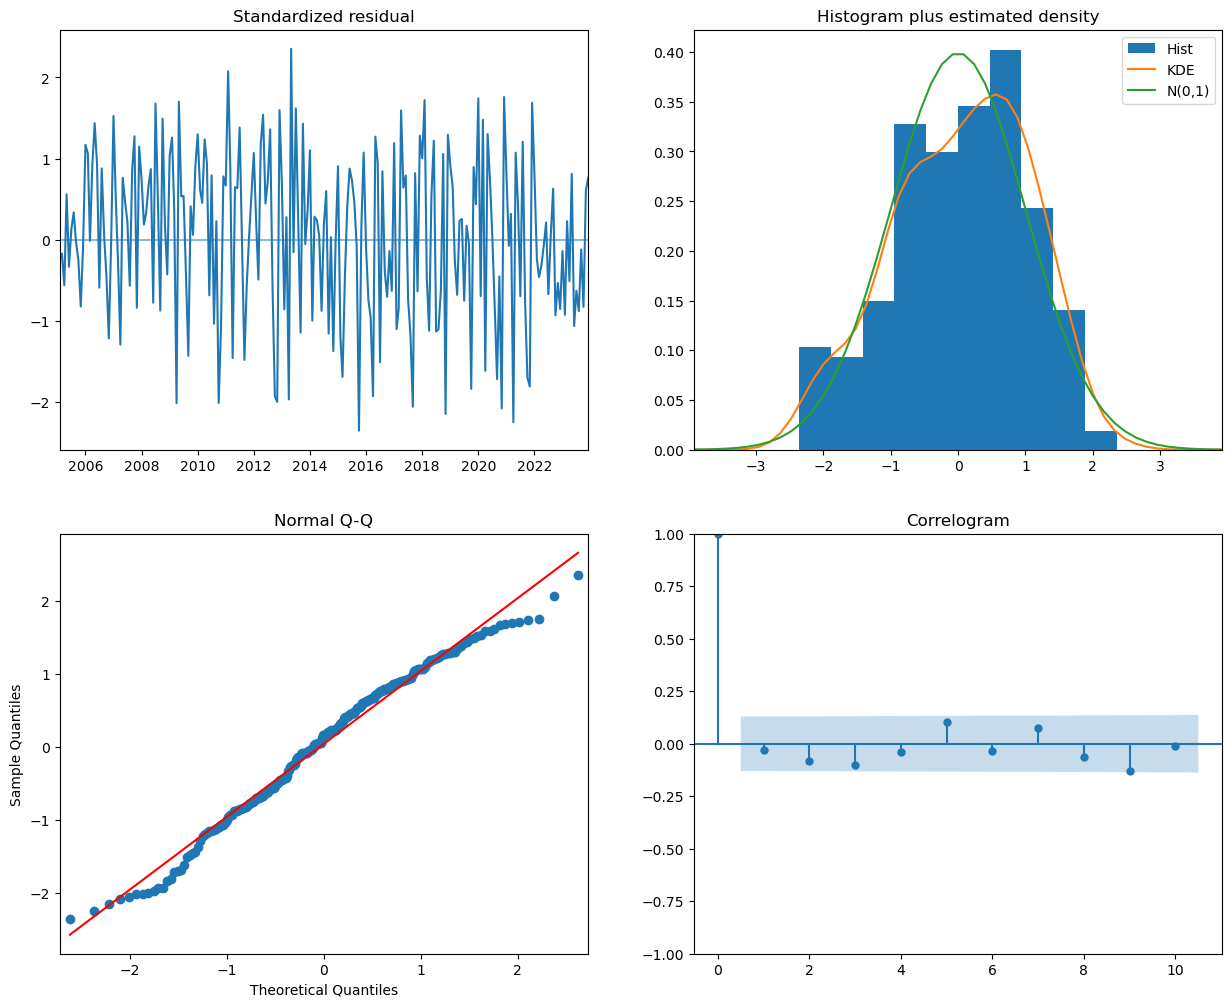

In [27]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [28]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -577.234
Date:                Mon, 02 Sep 2024   AIC                           1158.467
Time:                        14:06:00   BIC                           1165.317
Sample:                    01-01-2005   HQIC                          1161.231
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9145      0.029    -31.959      0.000      -0.971      -0.858
sigma2         9.3924      1.076      8.733      0.000       7.284      11.500
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 6.42
Prob(Q):                              0.65   Prob(JB):                         0.04
Heteroskedasticity (H):               1.28   Skew:                            -0.29
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2024-01-01    8.206029
2024-02-01    8.206029
2024-03-01    8.206029
2024-04-01    8.206029
2024-05-01    8.206029
2024-06-01    8.206029
2024-07-01    8.206029
2024-08-01    8.206029
2024-09-01    8.206029
2024-10-01    8.206029
2024-11-01    8.206029
2024-12-01    8.206029
2025-01-01    8.206029
2025-02-01    8.206029
2025-03-01    8.206029
2025-04-01    8.206029
2025-05-01    8.206029
2025-06-01    8.206029
2025-07-01    8.206029
2025-08-01    8.206029
2025-09-01    8.206029
2025-10-01    8.206029
2025-11-01    8.206029
2025-12-01    8.206029
Freq: MS, dtype: float64


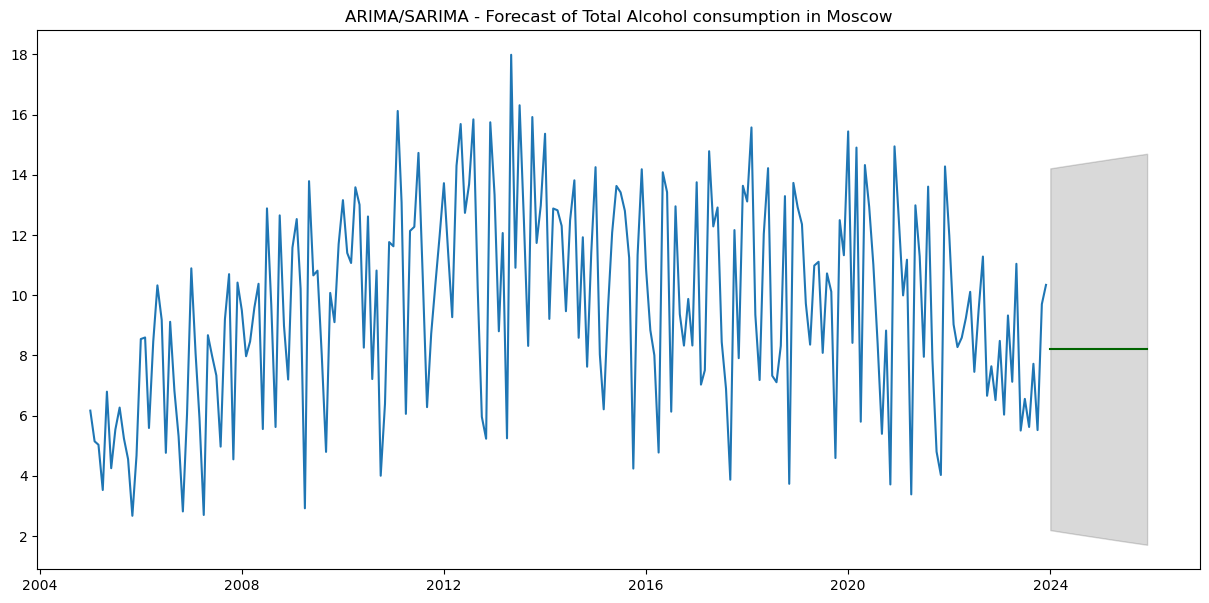

In [29]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_Moscow.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    print(fitted_series)
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_Moscow["total_alcohol"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Total Alcohol consumption in Moscow")
    plt.show()

forecast(ARIMA_model)

In [30]:
SARIMA_model = pm.auto_arima(df_Moscow["total_alcohol"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

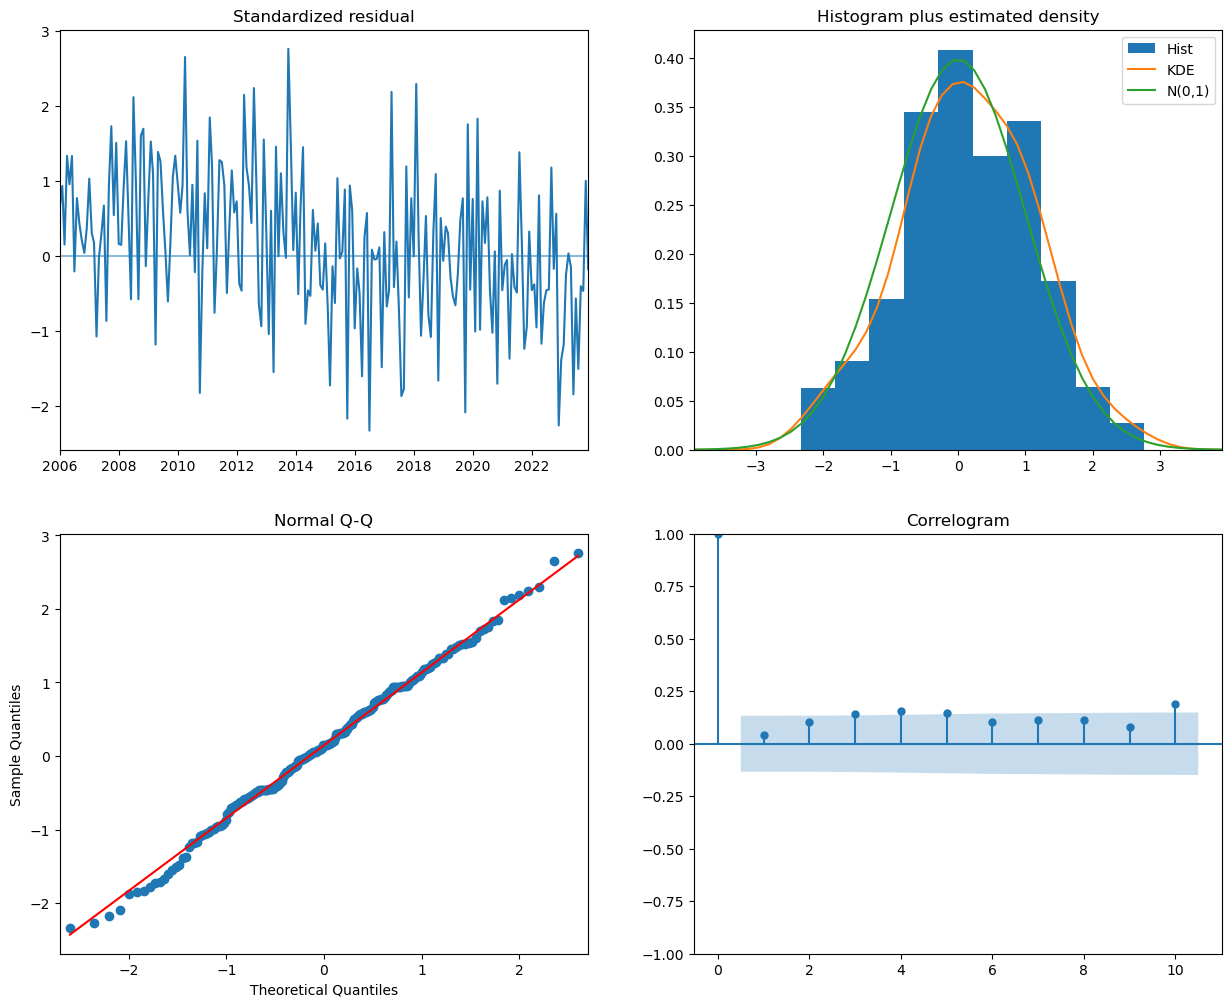

In [31]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

2017-01-01    10.586299
2017-02-01     8.203516
2017-03-01     6.852645
2017-04-01     5.373720
2017-05-01    10.845005
2017-06-01     8.850832
2017-07-01     8.953286
2017-08-01     8.255492
2017-09-01     4.802597
2017-10-01     6.753649
2017-11-01     5.631160
2017-12-01     9.513274
2018-01-01    10.376754
2018-02-01     7.994882
2018-03-01     6.644917
2018-04-01     5.166895
2018-05-01    10.639078
2018-06-01     8.645801
2018-07-01     8.749146
2018-08-01     8.052239
2018-09-01     4.600227
2018-10-01     6.552158
2018-11-01     5.430546
2018-12-01     9.313531
Freq: MS, dtype: float64


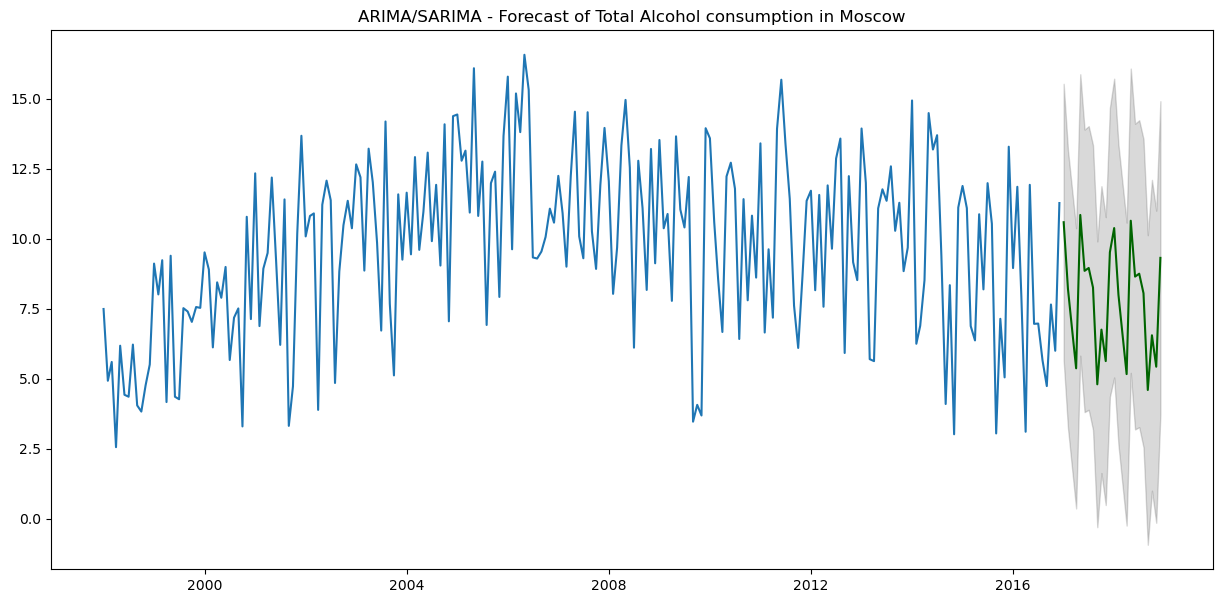

In [88]:
forecast(SARIMA_model)


In [34]:
df_Moscow

,region,wine,beer,vodka,champagne,brandy,total_alcohol,day,month,year,rolling_avg,rolling_std
dt,,,,,,,,,,,,
2005-01-01,Moscow,0.8230,3.1166,1.6852,0.4612,0.0824,6.1684,1,1,2005,NaN,NaN
2005-02-01,Moscow,0.2910,2.7856,1.8722,0.1713,0.0291,5.1492,1,2,2005,NaN,NaN
2005-03-01,Moscow,0.4332,2.1426,1.8865,0.4880,0.0847,5.0350,1,3,2005,5.450867,0.624020
2005-04-01,Moscow,0.7274,1.6078,1.0326,0.0844,0.0803,3.5325,1,4,2005,4.572233,0.902244
2005-05-01,Moscow,0.5896,3.4449,2.3502,0.3320,0.0811,6.7978,1,5,2005,5.121767,1.634378
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,Moscow,0.4031,4.2487,0.5960,0.2555,0.1224,5.6257,1,8,2023,5.896700,0.575709
2023-09-01,Moscow,0.1505,5.6994,1.4949,0.3118,0.0670,7.7236,1,9,2023,6.635733,1.051114
2023-10-01,Moscow,0.8359,3.9064,0.3863,0.2941,0.0996,5.5223,1,10,2023,6.290533,1.242149


SARIMAX

In [37]:
#adding exogenous variable
df_Moscow['month_index'] = df_Moscow.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df_Moscow[['total_alcohol']], exogenous=df_Moscow[['month']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

2024-01-01    11.173740
2024-02-01     8.330243
2024-03-01     9.821173
2024-04-01     7.064517
2024-05-01    11.335312
2024-06-01     9.088582
2024-07-01     7.659429
2024-08-01     8.552151
2024-09-01     8.509301
2024-10-01     6.429859
2024-11-01     7.765847
2024-12-01    10.688820
2025-01-01    11.173740
2025-02-01     8.330243
2025-03-01     9.821173
2025-04-01     7.064517
2025-05-01    11.335312
2025-06-01     9.088582
2025-07-01     7.659429
2025-08-01     8.552151
2025-09-01     8.509301
2025-10-01     6.429859
2025-11-01     7.765847
2025-12-01    10.688820
Freq: MS, dtype: float64


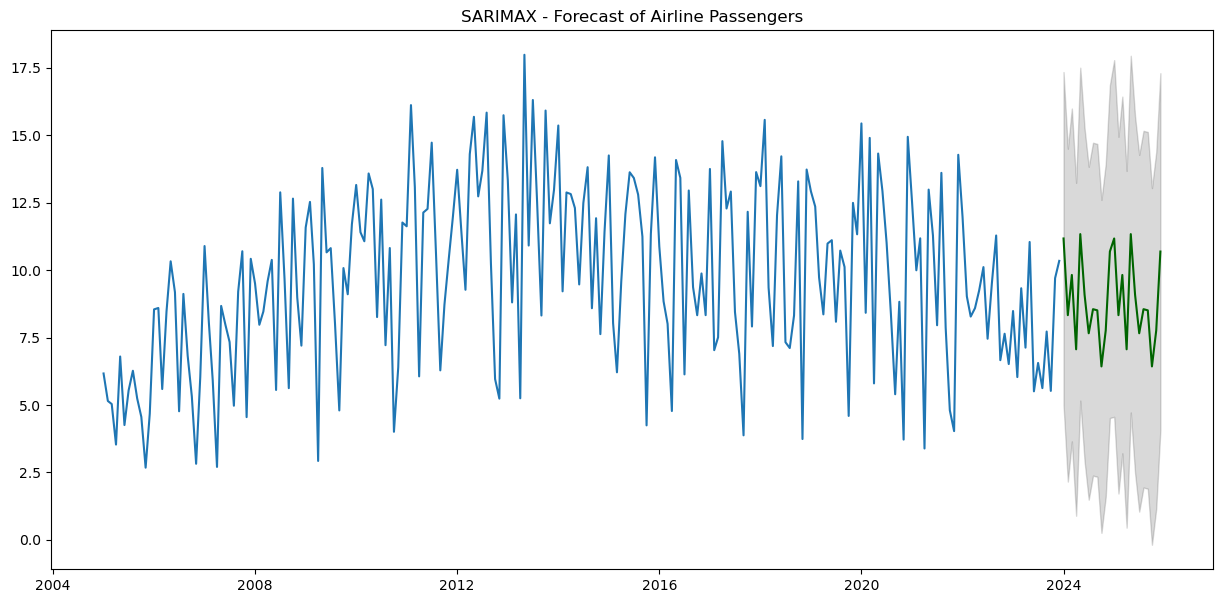

In [38]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"total_alcohol":pd.date_range(df_Moscow.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df_Moscow.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=df_Moscow[['month']])
    index_of_fc = pd.date_range(df_Moscow.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_Moscow["total_alcohol"], color='#1f76b4')
    print(fitted_series)
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)

In [70]:
sub_df_Moscow = df_Moscow['total_alcohol']


dtype('float64')

In [73]:


import itertools 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
def search_optimal_sarima(sub_df_Moscow, seasonal_cycle):
    # Define the ranges for p, d, q, and m (seasonal part of the model)
    order_vals = diff_vals = ma_vals = range(0, 2)
    
    # Generate all possible combinations of p, d, q values
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    
    # Add the seasonal parameter to each combination
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
    
    # Initialize variables to store the best model parameters and its AIC
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None
    
    # Iterate over all possible model configurations
    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                # Attempt to fit the SARIMAX model
                sarima_model = SARIMAX(sub_df_Moscow,
                                       order=order_param,
                                       seasonal_order=seasonal_param,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)

                model_results = sarima_model.fit(disp=False)  # Set disp=False to suppress unnecessary output
                
                # Update the best model parameters and AIC if necessary
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except Exception as e:
                # Print out errors for debugging purposes
                print(f"Error fitting model with params {order_param} and seasonal param {seasonal_param}: {e}")
                continue

    # Print the results
    print('SARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))


seasonal_cycle_length = 12
search_optimal_sarima(sub_df_Moscow, seasonal_cycle_length)

SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:1010.4076285843953


In [75]:
model = SARIMAX(sub_df_Moscow, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))


In [76]:
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46467D+00    |proj g|=  1.19592D-01

At iterate    5    f=  2.34861D+00    |proj g|=  9.17087D-03

At iterate   10    f=  2.34664D+00    |proj g|=  6.06385D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   7.117D-06   2.347D+00
  F =   2.3466432718932881     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [77]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      total_alcohol   No. Observations:                  228
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -535.035
Date:                            Mon, 02 Sep 2024   AIC                           1078.069
Time:                                    15:29:07   BIC                           1091.552
Sample:                                01-01-2005   HQIC                          1083.517
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1104      0.083     -1.326      0.185      -0.274       0.053
ma.L1         -0.8923      0.040   

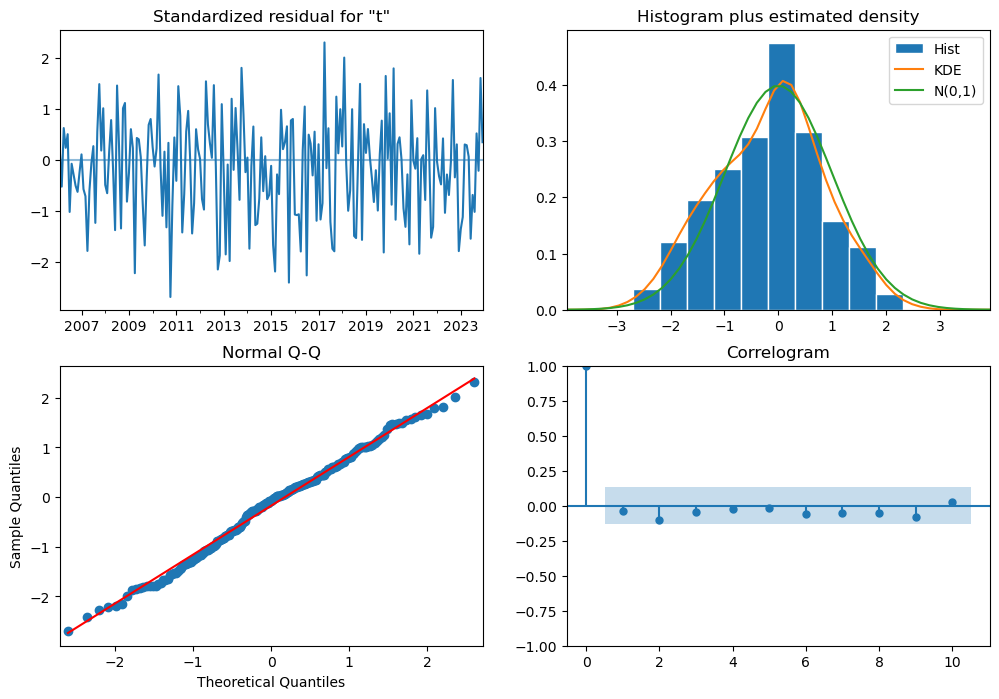

In [78]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

In [113]:
my = sub_df_Moscow.reset_index()
#my = my.set_index('dt')
#my.columns[0]

In [116]:
my

,dt,total_alcohol
0,2005-01-01,6.1684
1,2005-02-01,5.1492
2,2005-03-01,5.0350
3,2005-04-01,3.5325
4,2005-05-01,6.7978
...,...,...
223,2023-08-01,5.6257
224,2023-09-01,7.7236
225,2023-10-01,5.5223
226,2023-11-01,9.7040


In [127]:
from json import loads, dumps
from datetime import datetime
result = my.to_json(orient="records", date_format='iso')

#parsed = loads(result)
j = dumps(parsed, indent=4) 


clean_json_string = j.replace("\n", "")
print(clean_json_string)



[    {        "dt": "2005-01-01T00:00:00.000",        "total_alcohol": 6.1684    },    {        "dt": "2005-02-01T00:00:00.000",        "total_alcohol": 5.1492    },    {        "dt": "2005-03-01T00:00:00.000",        "total_alcohol": 5.035    },    {        "dt": "2005-04-01T00:00:00.000",        "total_alcohol": 3.5325    },    {        "dt": "2005-05-01T00:00:00.000",        "total_alcohol": 6.7978    },    {        "dt": "2005-06-01T00:00:00.000",        "total_alcohol": 4.2562    },    {        "dt": "2005-07-01T00:00:00.000",        "total_alcohol": 5.5385    },    {        "dt": "2005-08-01T00:00:00.000",        "total_alcohol": 6.2693    },    {        "dt": "2005-09-01T00:00:00.000",        "total_alcohol": 5.2429    },    {        "dt": "2005-10-01T00:00:00.000",        "total_alcohol": 4.5557    },    {        "dt": "2005-11-01T00:00:00.000",        "total_alcohol": 2.6761    },    {        "dt": "2005-12-01T00:00:00.000",        "total_alcohol": 4.6786    },    {        "dt

In [119]:
import json
from datetime import datetime

def convert_unix_to_iso(timestamp):
    return datetime.fromtimestamp(int(timestamp) // 1000).strftime('%Y-%m-%d')

json_data = json.loads(j)
for item in json_data:
    item['dt'] = convert_unix_to_iso(item['dt'])

clean_json_string = json.dumps(json_data, indent=4)
print(clean_json_string)

TypeError: the JSON object must be str, bytes or bytearray, not DataFrame

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

import warnings

warnings.filterwarnings("ignore")

# Prepare data
train_size = int(len(df_Moscow) * 0.8)
train_data, test_data = df_Moscow[0:train_size], df_Moscow[train_size:len(df_Moscow)+1]
print(f' train data len{len(train_data)}')
print(f' test data len {len(test_data)}')

# Function to calculate MSE and RMSE
def calculate_mse_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, rmse

# Function to calculate AIC and BIC
def calculate_aic_bic(model):
    return model.aic, model.bic

# Create a range of ARIMA models
p_values = range(1, 5)
d_values = range(0, 2)
q_values = range(0, 5)

best_model = None
best_aic = float('inf')
best_bic = float('inf')
best_mse = float('inf')
best_rmse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            model = ARIMA(train_data['total_alcohol'], order=(p,d,q))
            model_fit = model.fit()
            
            # Generate forecast
            forecast_steps = len(test_data)
           
            #forecast, stderr, conf_int = model_fit.forecast(steps=forecast_steps)
            forecast = model_fit.forecast(steps=forecast_steps)
            # Calculate metrics
            mse, rmse = calculate_mse_rmse(test_data['total_alcohol'], forecast)
            aic, bic = calculate_aic_bic(model_fit)
            
            # Store results
            print(f"p={p}, d={d}, q={q}: MSE={mse:.4f}, RMSE={rmse:.4f}, AIC={aic:.4f}, BIC={bic:.4f}")
            
            # Update best model if necessary
            if aic < best_aic:
                best_model = (p, d, q)
                best_aic = aic
                best_bic = bic
                best_mse = mse
                best_rmse = rmse

# Print the best model
print(f"\nBest ARIMA model: p={best_model[0]}, d={best_model[1]}, q={best_model[2]}")
print(f"Best metrics: AIC={best_aic:.4f}, BIC={best_bic:.4f}, MSE={best_mse:.4f}, RMSE={best_rmse:.4f}")



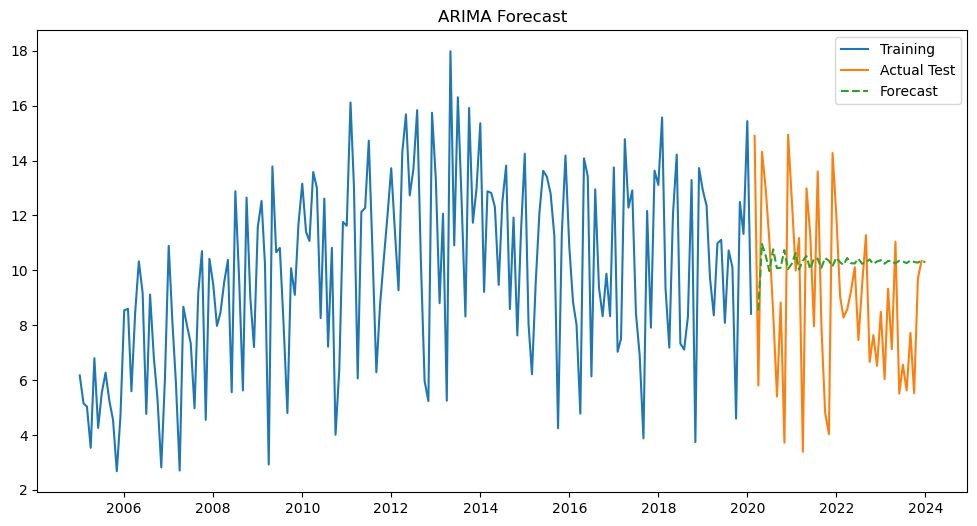

In [50]:
# Plot the forecast
import matplotlib.pyplot as plt
print()
plt.figure(figsize=(12,6))
#plt.plot(forecast,  label='Forecast')
plt.plot(train_data['total_alcohol'], label='Training')
plt.plot(test_data['total_alcohol'], label='Actual Test')
plt.plot(pd.date_range(start=test_data.index[0], periods=len(test_data), freq='M'), forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()